![image info](https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/images/banner_1.png)

# Taller: Construcción e implementación de modelos Bagging, Random Forest y XGBoost

En este taller podrán poner en práctica sus conocimientos sobre la construcción e implementación de modelos de Bagging, Random Forest y XGBoost. El taller está constituido por 8 puntos, en los cuales deberan seguir las intrucciones de cada numeral para su desarrollo.

## Datos predicción precio de automóviles

En este taller se usará el conjunto de datos de Car Listings de Kaggle donde cada observación representa el precio de un automóvil teniendo en cuenta distintas variables como año, marca, modelo, entre otras. El objetivo es predecir el precio del automóvil. Para más detalles puede visitar el siguiente enlace: [datos](https://www.kaggle.com/jpayne/852k-used-car-listings).

In [14]:
import warnings
warnings.filterwarnings('ignore')

In [15]:
# Importación de librerías
%matplotlib inline
import pandas as pd
import xgboost as xgb
from sklearn import metrics
from sklearn.model_selection import GridSearchCV, KFold
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score

# Lectura de la información de archivo .csv
data = pd.read_csv('https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/datasets/dataTrain_carListings.zip')

# Preprocesamiento de datos para el taller
data = data.loc[data['Model'].str.contains('Camry')].drop(['Make', 'State'], axis=1)
data = data.join(pd.get_dummies(data['Model'], prefix='M'))
data = data.drop(['Model'], axis=1)

# Visualización dataset
data.head()

,Price,Year,Mileage,M_Camry,M_Camry4dr,M_CamryBase,M_CamryL,M_CamryLE,M_CamrySE,M_CamryXLE
7,21995,2014,6480,False,False,False,True,False,False,False
11,13995,2014,39972,False,False,False,False,True,False,False
167,17941,2016,18989,False,False,False,False,False,True,False
225,12493,2014,51330,False,False,False,True,False,False,False
270,7994,2007,116065,False,True,False,False,False,False,False


In [16]:
# Estadisticas de los datos
print(data.describe())
print()
# Contar NaNs en los valores de data
print(data.isnull().sum())

              Price          Year        Mileage
count  10495.000000  10495.000000   10495.000000
mean   14538.403716   2013.553883   52509.430395
std     3922.420961      3.116585   36791.736601
min     5002.000000   1998.000000       5.000000
25%    11999.000000   2012.000000   26461.000000
50%    15000.000000   2014.000000   41680.000000
75%    16999.000000   2016.000000   71355.500000
max    32444.000000   2018.000000  232658.000000

Price          0
Year           0
Mileage        0
M_Camry        0
M_Camry4dr     0
M_CamryBase    0
M_CamryL       0
M_CamryLE      0
M_CamrySE      0
M_CamryXLE     0
dtype: int64


In [17]:
# Separación de variables predictoras (X) y variable de interés (y)
y = data['Price']
X = data.drop(['Price'], axis=1)

In [18]:
# Separación de datos en set de entrenamiento y test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

### Punto 1 - Árbol de decisión manual

En la celda 1 creen un árbol de decisión **manualmente**  que considere los set de entrenamiento y test definidos anteriormente y presenten el RMSE y MAE del modelo en el set de test.

En la siguiente celda de codigo se construye el árbol de decisión manual para el caso de regresión. Las variables tipo bool de los datos se pasan a valores numericos con el fin de entrenar el modelo.

In [19]:
# Celda 1
'''
Para el entrenamiento del arbol de decision se deben tratar las variables
tipo bool para convertirlas a numericas
'''
# Verificar los tipos de datos
print(X.dtypes)
print('\n\n')
# Convertir columnas booleanas a enteros
bool_cols = [col for col in X.columns if X[col].dtype == 'bool']
X[bool_cols] = X[bool_cols].astype(int)

# Verificar los tipos de datos después de la conversión
print(X.dtypes)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# Definición de parámetros y criterios de parada
max_depth = None
num_pct = 10
max_features = None
min_gain=0.001

# Definición de la función que calcula la varianza
def varianza(y):
  if y.shape[0] == 0:
    return 0
  else:
    return np.var(y, ddof=1)

# Función de impureza basada en la varianza
def varianza_impurity(X_col, y, split):
  filter_l = X_col < split
  y_l = y.loc[filter_l]
  y_r = y.loc[~filter_l]

  n_l = y_l.shape[0]
  n_r = y_r.shape[0]

  var_y = varianza(y)
  var_l = varianza(y_l)
  var_r = varianza(y_r)

  peso_var = (n_l / (n_l + n_r) * var_l) + (n_r / (n_l + n_r) * var_r)
  var_impurity_ = var_y - peso_var

  return var_impurity_

# Función para encontrar el mejor split
def best_split(X, y, num_pct=10):
  features = range(X.shape[1])
  best_split = [0, 0, np.inf]  # inf para garantizar comparación

  # Para todas las variables
  for j in features:
    splits = np.percentile(X.iloc[:, j], np.arange(0, 100, 100.0 / (num_pct+1)).tolist())
    splits = np.unique(splits)[1:]

    for split in splits:
      gain = varianza_impurity(X.iloc[:, j], y, split)
      if gain < best_split[2]:  # Buscar el menor error
        best_split = [j, split, gain]

  return best_split

# Función para crecer el árbol de manera recursiva
def tree_grow(X, y, level=0, min_gain=0.001, max_depth=None, num_pct=10):

  # Si solo es una observación
  if X.shape[0] == 1:
    tree = {'y_pred': y.iloc[0], 'level': level, 'split': -1, 'n_samples': 1, 'gain': 0}
    return tree

  # Calcular la mejor división
  j, split, gain = best_split(X, y, num_pct)

  # Guardar el árbol y estimar la predicción
  y_pred = y.mean()

  tree = {'y_pred': y_pred, 'level': level, 'split': -1, 'n_samples': X.shape[0], 'gain': gain}

  # Revisar el criterio de parada
  if gain < min_gain:
    return tree
  if max_depth is not None and level >= max_depth:
    return tree

  filter_l = X.iloc[:, j] < split
  X_l, y_l = X.loc[filter_l], y.loc[filter_l]
  X_r, y_r = X.loc[~filter_l], y.loc[~filter_l]
  tree['split'] = [j, split]

  tree['sl'] = tree_grow(X_l, y_l, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)
  tree['sr'] = tree_grow(X_r, y_r, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)

  return tree

Year           int64
Mileage        int64
M_Camry         bool
M_Camry4dr      bool
M_CamryBase     bool
M_CamryL        bool
M_CamryLE       bool
M_CamrySE       bool
M_CamryXLE      bool
dtype: object



Year           int64
Mileage        int64
M_Camry        int32
M_Camry4dr     int32
M_CamryBase    int32
M_CamryL       int32
M_CamryLE      int32
M_CamrySE      int32
M_CamryXLE     int32
dtype: object


En esta celda de codigo se realiza el arbol de decisión sobre los datos de entrenamiento `X_train` y `y_train`

In [20]:
# Aplicación de la función tree_grow
tree = tree_grow(X_train, y_train, level=0, min_gain=0.001, max_depth=3, num_pct=10)
tree

{'y_pred': 14508.073389276064,
 'level': 0,
 'split': [6, 1.0],
 'n_samples': 7031,
 'gain': 2484.133072089404,
 'sl': {'y_pred': 14471.201980568012,
  'level': 1,
  'split': [8, 1.0],
  'n_samples': 5352,
  'gain': 937559.6287543327,
  'sl': {'y_pred': 14067.977427131273,
   'level': 2,
   'split': [1, 18007.090909090908],
   'n_samples': 4563,
   'gain': 2033156.1282573473,
   'sl': {'y_pred': 18576.89156626506,
    'level': 3,
    'split': -1,
    'n_samples': 415,
    'gain': 10778.462037846446},
   'sr': {'y_pred': 13616.868611378977,
    'level': 3,
    'split': -1,
    'n_samples': 4148,
    'gain': 141027.38796816766}},
  'sr': {'y_pred': 16803.15842839037,
   'level': 2,
   'split': [1, 11953.363636363638],
   'n_samples': 789,
   'gain': 2449586.0361421835,
   'sl': {'y_pred': 21752.222222222223,
    'level': 3,
    'split': -1,
    'n_samples': 72,
    'gain': 150248.94532922097},
   'sr': {'y_pred': 16306.181311018132,
    'level': 3,
    'split': -1,
    'n_samples': 717,


En esta celda se calcula el RMSE y MAE sobre los datos de test prediciendo con el arbol de decisión creado anteriormente.

In [21]:
def tree_predict(X, tree):
    predicted = np.zeros(X.shape[0])

    # Revisar si es el nodo final
    if tree['split'] == -1:
        predicted[:] = tree['y_pred']
    else:
        j, split = tree['split']
        filter_l = X.iloc[:, j] < split
        filter_r = ~filter_l

        if X.loc[filter_l].shape[0] > 0:
            predicted[filter_l] = tree_predict(X.loc[filter_l], tree['sl'])
        if X.loc[filter_r].shape[0] > 0:
            predicted[filter_r] = tree_predict(X.loc[filter_r], tree['sr'])

    return predicted

# Preparar el conjunto de datos de prueba para la predicción
y_pred = tree_predict(X_test, tree)

# Calcular RMSE y MAE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

print("RMSE:", rmse)
print("MAE:", mae)

RMSE: 3493.7415606484115
MAE: 2812.610387461701


### Punto 2 - Bagging manual

En la celda 2 creen un modelo bagging **manualmente** con 10 árboles de regresión y comenten sobre el desempeño del modelo.

In [22]:
# Celda 2
# Configuración inicial
np.random.seed(1)

# Creación de muestras de bootstrap
n_samples = X.shape[0]
n_B = 10  # Número de árboles en el ensamble
samples = [np.random.choice(a=len(X_train), size=len(X_train), replace=True) for _ in range(n_B)]

# Definición del modelo usando DecisionTreeRegressor de sklearn
treereg = DecisionTreeRegressor(max_depth=None, random_state=1)

# Preparación del DataFrame para almacenar predicciones de cada árbol
y_pred = pd.DataFrame(index=X_test.index, columns=[f"Tree_{i}" for i in range(n_B)])

# Entrenar un árbol de decisión para cada muestra bootstrap y predecir el conjunto de y
for i, sample in enumerate(samples):
  X_train_bs = X_train.iloc[sample]
  y_train_bs = y_train.iloc[sample]
  treereg.fit(X_train_bs, y_train_bs)
  y_pred[f"Tree_{i}"] = treereg.predict(X_test)

# Evaluación del desempeño de cada árbol
for i in range(n_B):
    print(f'Árbol {i} tiene un RMSE: {np.sqrt(mean_squared_error(y_test, y_pred[f"Tree_{i}"]))}')

# Predicción promedio para cada observación del conjunto de test
y_pred_mean = y_pred.mean(axis=1)

# Error RMSE al promediar las predicciones de todos los árboles
rmse = np.sqrt(mean_squared_error(y_test, y_pred_mean))
print(f'RMSE promedio de todos los árboles: {rmse}')

Árbol 0 tiene un RMSE: 2115.398641252809
Árbol 1 tiene un RMSE: 2118.8628835947165
Árbol 2 tiene un RMSE: 2115.824242590595
Árbol 3 tiene un RMSE: 2079.612974501977
Árbol 4 tiene un RMSE: 2133.1731849246876
Árbol 5 tiene un RMSE: 2120.298692545029
Árbol 6 tiene un RMSE: 2131.672528013512
Árbol 7 tiene un RMSE: 2124.4514829000846
Árbol 8 tiene un RMSE: 2081.2285413176396
Árbol 9 tiene un RMSE: 2139.8806118763787
RMSE promedio de todos los árboles: 1779.5963450840588


Cuando combinamos los 10 árboles de decisión generados mediante el proceso de bagging, observamos una mejora significativa en el desempeño en comparación con el árbol de decisión individual creado en el punto 1, particularmente al evaluar mediante la métrica RMSE. Específicamente, el enfoque de bagging logra un RMSE promedio de 1779.59, lo cual es notablemente más bajo que el RMSE de 3493.74 obtenido por el árbol de decisión individual. Esta diferencia destaca la eficacia del bagging para reducir la varianza y mejorar la precisión de las predicciones en modelos complejos de aprendizaje automático.

### Punto 3 - Bagging con librería

En la celda 3, con la librería sklearn, entrenen un modelo bagging con 10 árboles de regresión y el parámetro `max_features` igual a `log(n_features)` y comenten sobre el desempeño del modelo.

In [25]:
# Celda 3
# Uso de BaggingRegressor de la libreria (sklearn) donde se usa el modelo DecisionTreeRegressor como estimador
n_features = X_train.shape[1]
bagreg = BaggingRegressor(base_estimator=DecisionTreeClassifier(max_features="log2"), n_estimators=10, bootstrap=True, oob_score=True, random_state=42)


# Entrenemiento del modelo con set de entrenamiento y predicción en el set de test
bagreg.fit(X_train, y_train)
y_pred_bagging = bagreg.predict(X_test).astype(int)

#Calcular medidas de desempeño
# Calcular el error cuadrático medio (MSE)
mse = mean_squared_error(y_test, y_pred_bagging)

# Calcular el coeficiente de determinación (R²)
r2 = r2_score(y_test, y_pred_bagging)

print("Mean Squared Error (MSE):", mse)
print("R-squared (R²):", r2)

Mean Squared Error (MSE): 3329311.4959584298
R-squared (R²): 0.7823431116479687


**Desempeño del Modelo**

Según los resultados obtenidos, podemos concluir que el modelo tiene un buen rendimiento en términos de ajuste a los datos, por el valor obtenido de R², pero aún hay alta variabilidad respecto a la precisión de las predicciones teniendo en cuenta que se obtuvo un MSE alto.

### Punto 4 - Random forest con librería

En la celda 4, usando la librería sklearn entrenen un modelo de Randon Forest para regresión  y comenten sobre el desempeño del modelo.

In [26]:
# Celda 4
# Definición de modelo Random Forest para un problema de clasificación
reg_RF = RandomForestRegressor(random_state=0)
reg_RF.fit(X_train, y_train)

# Predicción
y_pred_RF = reg_RF.predict(X_test)

# Cálculo del desempeño
mse_RF = mean_squared_error(y_test, y_pred_RF)
print('El error cuadrático medio para el modelo Random Forest es de:', mse_RF)
# Calcular el coeficiente de determinación (R²)
r2_RF = r2_score(y_test, y_pred_RF)

print('El coeficiente de determinación (R²) para el modelo Random Forest es de:', r2_RF)

El error cuadrático medio para el modelo Random Forest es de: 3101046.819865033
El coeficiente de determinación (R²) para el modelo Random Forest es de: 0.7972661307705365


**Desempeño del Modelo**

Similar al resultado del modelo en el punto anterior, el resultado de R² es alto lo que significa un buen rendimiento en términos de ajuste a los datos pero el MSE indica que aún hay oportunidad de ajuste y mejora para reducir aún más el MSE.
Adicionalmente, aunque ambos modelos muestran un buen ajuste a los datos, el modelo Random Forest parece tener un rendimiento un poco mejor en términos de precisión de las predicciones (MSE menor).

### Punto 5 - Calibración de parámetros Random forest

En la celda 5, calibren los parámetros max_depth, max_features y n_estimators del modelo de Randon Forest para regresión, comenten sobre el desempeño del modelo y describan cómo cada parámetro afecta el desempeño del modelo.

### Calibración de n_estimators
**n_estimators** es la cantidad de árboles a contruir dentro del bosque aleatorio..

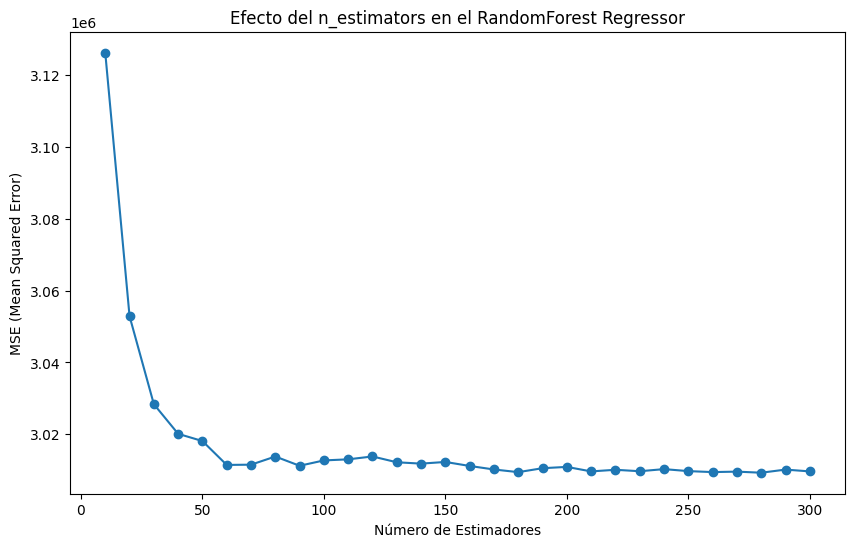

In [27]:
# Celda 5
#Creación de lista de valores para iterar sobre diferentes valores de n_estimators
estimator_range = range(10, 310, 10)

# Lista para almacenar MSE
mse_scores = []

# posibles valores de n_estimators para evaluar cada uno
for estimator in estimator_range:
    # Crear un RandomForestRegressor con el número de estimadores actual
    rf = RandomForestRegressor(n_estimators=estimator, random_state=1, n_jobs=-1)

    # Calcula el MSE usando cross-validation y toma la media de los scores
    mse = cross_val_score(rf, X_train, y_train, cv=5, scoring='neg_mean_squared_error').mean()

    # Almacenar el score negativo (para hacerlo positivo ya que 'neg_mean_squared_error' devuelve valores negativos)
    mse_scores.append(-mse)

# Gráfica de la cantidad de n_estimators vs MSE
plt.figure(figsize=(10, 6))
plt.plot(estimator_range, mse_scores, marker='o')
plt.xlabel('Número de Estimadores')
plt.ylabel('MSE (Mean Squared Error)')
plt.title('Efecto del n_estimators en el RandomForest Regressor')
plt.show()

##Calibracion profundidad (max_depth)

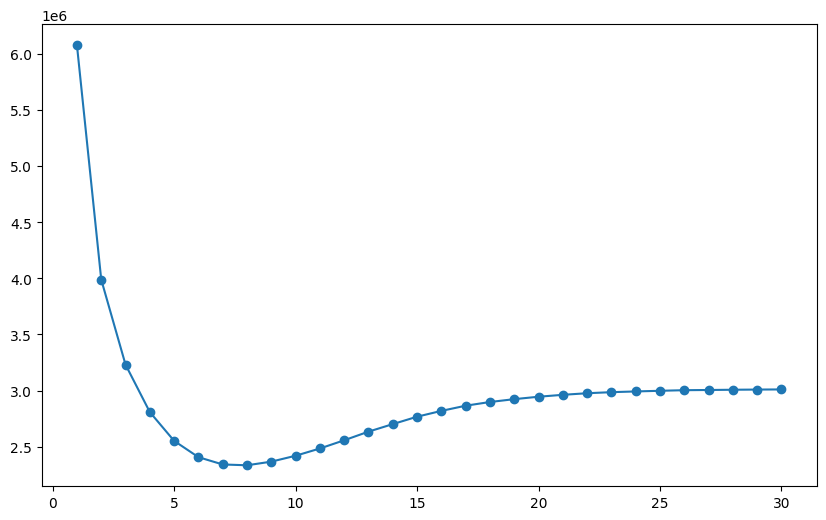

In [28]:
# Rango de profundidades a probar
depth_range = range(1, 31)
mse_scores = []

# Prueba cada profundidad
for depth in depth_range:
    rf = RandomForestRegressor(max_depth=depth, n_estimators=100, random_state=1, n_jobs=-1)
    mse = cross_val_score(rf, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    mse_scores.append(-np.mean(mse))  # Convertimos MSE a positivo

# Gráfica del desempeño del modelo vs la profundidad máxima
plt.figure(figsize=(10, 6))
plt.plot(depth_range, mse_scores, marker='o')

Calibracióm max_features
max_features es el número de variables que se deben considerar en cada árbol.

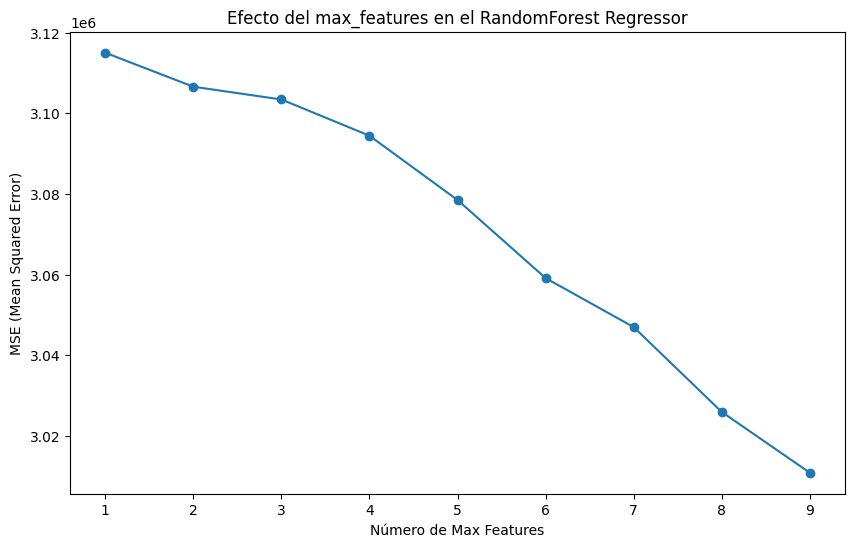

In [29]:
feature_cols = X.columns
# Preparación de la lista de valores posibles para max_features
feature_range = range(1, len(feature_cols)+1)  # De 1 hasta el número total de características

# Lista para almacenar las puntuaciones de MSE para cada configuración de max_features
mse_scores = []

# Bucle sobre los posibles valores de max_features para evaluar cada uno
for feature in feature_range:
    # Crear un RandomForestRegressor con el número actual de max_features
    rf = RandomForestRegressor(n_estimators=200, max_features=feature, random_state=1, n_jobs=-1)

    # Calcula el MSE usando cross-validation y toma la media de los scores
    mse = cross_val_score(rf, X_train, y_train, cv=5, scoring='neg_mean_squared_error').mean()

    # Almacenar el score negativo (para hacerlo positivo, ya que 'neg_mean_squared_error' devuelve valores negativos)
    mse_scores.append(-mse)

# Gráfica de la cantidad de max_features vs MSE
plt.figure(figsize=(10, 6))
plt.plot(feature_range, mse_scores, marker='o', linestyle='-')
plt.xlabel('Número de Max Features')
plt.ylabel('MSE (Mean Squared Error)')
plt.title('Efecto del max_features en el RandomForest Regressor')
plt.show()

## Implementación de un Random Forest con los mejores parámetros

MSE: 2447253.8346487177
R-squared: 0.8400084656230473


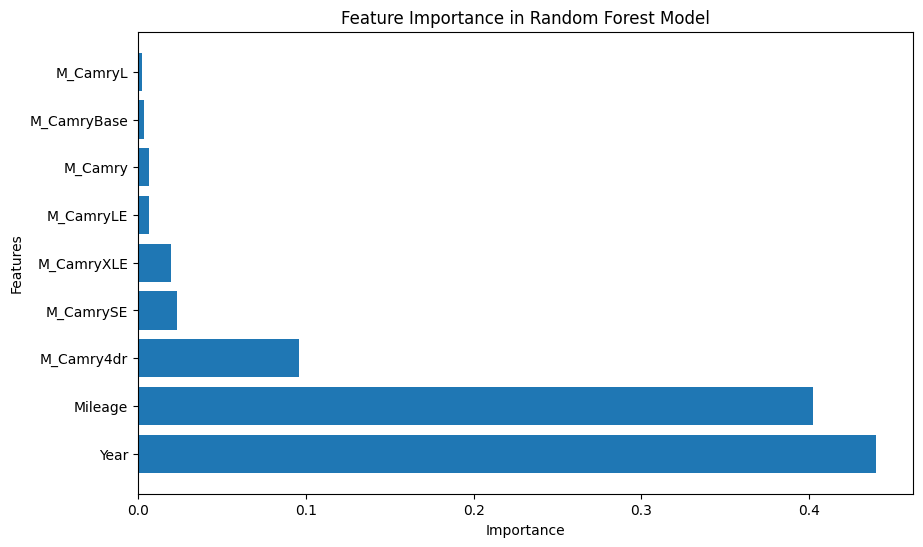

In [30]:
# Implementación del modelo Random Forest con los parámetros óptimos
clf = RandomForestRegressor(n_estimators=100, max_features=3, max_depth=7, random_state=1, n_jobs=-1)
clf.fit(X_train, y_train)

# Predicción sobre el conjunto de prueba
y_pred = clf.predict(X_test)

# Cálculo de métricas de desempeño, como el MSE y el R²
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'MSE: {mse}')
print(f'R-squared: {r2}')

# Análisis de la importancia de las características
feature_importances = pd.DataFrame({'feature': feature_cols, 'importance': clf.feature_importances_})
sorted_importances = feature_importances.sort_values(by='importance', ascending=False)

# Visualización de la importancia de las características
plt.figure(figsize=(10, 6))
plt.barh(sorted_importances['feature'], sorted_importances['importance'])
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Feature Importance in Random Forest Model')
plt.show()

##Conclusiones

El MSE ha disminuido de 3,101,046.82 a 2,447,253.83. Esta reducción en el MSE indica que el modelo calibrado tiene un error promedio menor en sus predicciones comparado con el modelo sin calibrar. El modelo ajustado se ajusta mejor a los datos, reduciendo los errores de predicción.

El coeficiente R-squared ha aumentado de 0.7973 a 0.8400. Un incremento en R-squared significa que el modelo calibrado explica una mayor proporción de esa variabilidad, indicando una mejora en la capacidad predictiva y la eficacia del modelo.

---

Ajustar el max_depth a 7, n_estimators a 100 y max_features a 3, ha permitido que el modelo evite sobreajustes y mejore su generalización.

*   **max_depth** controla la complejidad del modelo, permitiéndole aprender patrones más generalizables sin capturar detalles excesivos que no se traducen bien fuera de la muestra de entrenamiento.
*   **max_features** ayuda a mejorar la robustez del modelo contra el sobreajuste.
*   **n_estimators** evita errores individuales de árboles específicos afecten demasiado el resultado global.

### Punto 6 - XGBoost con librería

En la celda 6 implementen un modelo XGBoost de regresión con la librería sklearn y comenten sobre el desempeño del modelo.

In [31]:
# Celda 6
### Se crea el modelo mas sencillo sin modifcar parametros
model_XGBReg = xgb.XGBRegressor()
model_XGBReg.fit(X_train, y_train)
### Se genera la prediccion con este modelo
y_pred_XGBReg = model_XGBReg.predict(X_test)
### Se realiza el calculo de la metrica MSE
mse_XGBReg = metrics.mean_squared_error(y_pred_XGBReg, y_test)
rmse_XGBReg = np.sqrt(mse_XGBReg)
print("El RMSE obtenido con este modelo es de:",rmse_XGBReg)

El RMSE obtenido con este modelo es de: 1605.2355199928948


Analisis:
Este resultado es alto debido a que este primer modelo es el resultado de crearlo sin modificar los hiperparametros para ajustarlo o calibrarlo.
La razon para realizar esto es porque en el siguiente punto es calibrar estos hiperparametros asi que la idea es notar la diferencia del resultado de un modelo base a uno calibrado.

### Punto 7 - Calibración de parámetros XGBoost

En la celda 7 calibren los parámetros learning rate, gamma y colsample_bytree del modelo XGBoost para regresión, comenten sobre el desempeño del modelo y describan cómo cada parámetro afecta el desempeño del modelo.

In [32]:
# Celda 7
## Primero se crea un diccionario para definir los hiperparametros que queremos ajustar en el modelo:
params = {
    'learning_rate': [0.001, 0.01, 0.05, 0.1, 0.2],
    'gamma': [0, 0.1, 0.2, 0.5, 0.7],
    'colsample_bytree': [0.4, 0.6, 0.8, 0.9, 1.0]
}

## Se crea el modelo V2
model_XGBReg_v2 = xgb.XGBRegressor()

## Se define los folds o divisiones de la validacion cruzada y se definie el metodo a usar
kf = KFold(n_splits=5, shuffle=True, random_state=42)  # 5-fold cross-validation
valid_cruz_param = GridSearchCV(estimator=model_XGBReg_v2, param_grid=params, cv=kf, scoring='neg_mean_squared_error', verbose=1)

# Se ajusta el modelo con la validacion cruzada con busqueda del parametro
valid_cruz_param.fit(X, y)

Fitting 5 folds for each of 125 candidates, totalling 625 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    inte...
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=None, ...),
             param_grid={'colsample_bytree': [0.4, 0.6, 0.8, 0.9, 1.0],
                         'gamma': [0, 0.1, 0.2, 0.5, 0.7],
                         'learning_rate': [0.001, 0.01, 0.05, 0.1, 0.2]},
             scoring='neg_mean_squared_error', verbose=1)

Ahora se realiza la prediccion de la muestra de prueba

In [33]:
## Se toma el mejor modelo de la validacion cruzada
mejores_parametros = valid_cruz_param.best_params_
model_XGBReg_v2_F = valid_cruz_param.best_estimator_
### Se genera la prediccion con este modelo
y_pred_XGBReg_v2 = model_XGBReg_v2_F.predict(X_test)
### Se realiza el calculo de la metrica MSE
mse_XGBReg_v2 = metrics.mean_squared_error(y_pred_XGBReg_v2, y_test)
rmse_XGBReg_v2 = np.sqrt(mse_XGBReg_v2)
print("El RMSE obtenido con este modelo es de:",rmse_XGBReg_v2)

El RMSE obtenido con este modelo es de: 1473.868247866107


In [34]:
## Se observa cuales fueron los hiperparametros que dieron el mejor modelo
print(mejores_parametros)

{'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.05}


_Analisis:_  
Para entender la calibracion o ajuste que se realizo en el modelo, se debe entender la finalidad de cada uno de estos parametros:  
1. **Gamma**: Este parametro ayuda a controlar la regularizacion del modelo, ya que este especifica el valor minimo de reduccion en el error de prediccion al tratar de generar un nuevo nodo en el arbol. valores muy pequeños podrian hacer que el modelo se sobreajuste, valores muy grandes que haya falta de ajuste.
2. **colsample_bytree**: Este parametro controla basicamente la proporcion de las caracteristicas o predictores que se usan de manera aleatoria para la construccion de un Arbol. Si el valor es de 1, significa que que usara el 100% de los predictores en la construccion del arbol. Si se usara el valor de 0.6 significa que toma el 60% de los predictos de manera aleatoria para construir los arboles.
3. **learning_rate**: Este parametro tambien conocido como la tasa de aprendizaje permite "controlar la velocidad de aprendizaje del modelo" ya que si manejamos un valor bajo de este parametro, hace que la contribucion de cada arbol sea mas baja permitiendo asi un tipo de regularizacion.

Con base a esto los valores de los parametros obtenidos son:  
* **colsample_bytree** de 0.8. Significa que tomara el 80% de las variables predictoras para la construccion del modelo.
* **Gamma** de 0. Sginifica que no se impone una regla con base a la reduccion de la perdida al crear los nodos.
* **learning_rate** de 0.05. Es la penalizacion o regularizacion que impondra en la creacion de nuevos arboles.

### Punto 8 - Comparación y análisis de resultados
En la celda 8 comparen los resultados obtenidos de los diferentes modelos (random forest y XGBoost) y comenten las ventajas del mejor modelo y las desventajas del modelo con el menor desempeño.

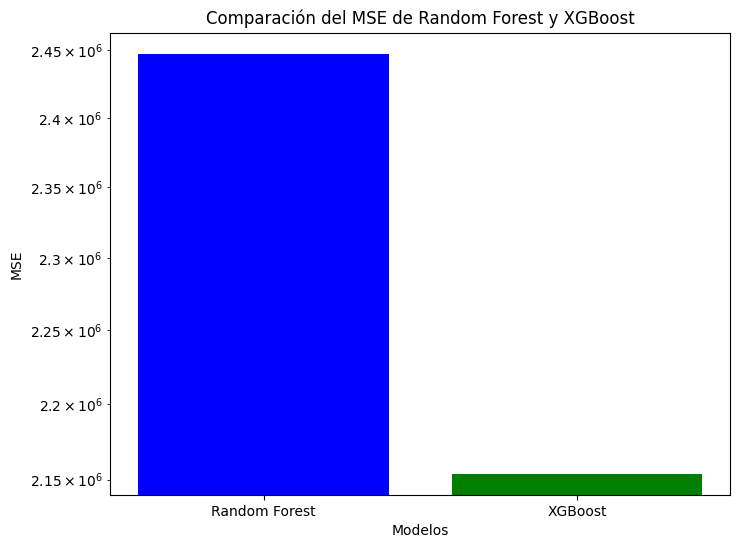

In [35]:
# Celda 8
# RMSE de XGBoost
rmse_xgb = 1467.5940820895294

# Convertir RMSE a MSE para comparación
mse_xgb = rmse_xgb ** 2

# MSE de Random Forest
mse_rf = 2447253.8346487177

# Datos para graficar
models = ['Random Forest', 'XGBoost']
mse_values = [mse_rf, mse_xgb]

# Crear gráfico de barras
plt.figure(figsize=(8, 6))
plt.bar(models, mse_values, color=['blue', 'green'])
plt.xlabel('Modelos')
plt.ylabel('MSE')
plt.title('Comparación del MSE de Random Forest y XGBoost')
plt.yscale('log')  # Escala logarítmica para mejor visualización
plt.show()

##Random Forest :
MSE: 2,447,253.83


##XGBoost:
MSE: 2,152,167.77


Ambos modelos muestran un desempeño similar en términos de MSE, aunque el de XGBoost tiene mejor capacidad para minimizar el error cuadrático medio

**Random Forest:**


Ventajas:
El modelo muestra un buen ajuste con un R-squared de 0.8400, indicando que explica el 84% de la variabilidad en los precios del automóvil.
Puede manejar automáticamente características categóricas y numéricas sin la necesidad de escalado previo.


Desventajas:
Puede ser computacionalmente más costoso y más lento para entrenar, especialmente con un gran número de árboles y profundidad.

**XGBoost:**


Ventajas:
Muy eficiente en términos de velocidad y rendimiento, especialmente en conjuntos de datos grandes y en la presencia de muchas características.
Proporciona un mejor rendimiento ajustando características específicas como learning rate, gamma, y colsample_bytree.


Desventajas:
La configuración de hiperparámetros puede ser más compleja y requiere una cuidadosa validación cruzada para optimizarlos adecuadamente.
Más susceptible al sobreajuste si no se calibra adecuadamente, especialmente en datos con mucha variabilidad.


Conclusión:


El modelo XGBoost calibrado tiene un desempeño superior al de Random Forest en términos de RMSE, lo cual es un indicativo de mejores predicciones y menor error. Esto puede hacer que XGBoost sea más adecuado para aplicaciones donde la precisión es crítica.